In [85]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import statistics

/*

Ten notebook ma na celu znalezienie najbardziej odpowieedniej metody ustalania thresholdu, na podstawie którego wyznaczane są anomalie. Sprawdzone do tej pory metody:
    
    - ustawienie thresholdu na 95% (czyli 5% danych, w których wartość błędu jest najwyższa, zostaje zaklasyfikowane jako anomalia)
    - ustawienie thresholdu w 0.6 odległości między najmniejszą wartością błędu (najlepsza metoda)
    - ustawienie tresholdu na poziomie odchylenia standardowego

TODO:

    - obliczenie tych wartości dla konkretnyc timestampów
    
*/

In [86]:
def percent_treshold(test_mae_loss):
    pom = list(test_mae_loss)
    pom.sort()
    TRESHOLD = pom[int(len(pom)*0.95)]
    return(TRESHOLD[0])

def normalised_treshold(test_mae_loss):
    pom = list(test_mae_loss)
    TRESHOLD = (max(pom) - min(pom))*0.45
    return TRESHOLD[0]

def stdev_treshold(test_mae_loss):  
    test_mae_loss = test_mae_loss.reshape(len(test_mae_loss))
    return statistics.stdev(test_mae_loss)

In [87]:
file_name = "ANIX"
model = load_model("1000files_64.h5")
TIME_STEPS = 30

In [88]:
data = open(f"data1/{file_name}.csv")
close_value = []
x_test = []
y_test = []
pom = 0
for line in data:

    if pom ==0 or line == '\n':
        pom =1
        continue
    line = line.replace('\n', '')
    close_value.append([float(line.split(',')[2])])

max_value = max(close_value)[0]
min_value = min(close_value)[0]

for i in range(len(close_value)-TIME_STEPS):
    x_list = []
    for x1 in close_value[i:i+TIME_STEPS]:
        x_list.append([(x1[0]-min_value)/(max_value-min_value)])
    x_test.append(x_list)
    y_test.append([(close_value[i + TIME_STEPS][0]- min_value)/(max_value-min_value)])

In [89]:
X_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(X_test_pred - x_test), axis=1)

label_x = list(np.arange(len(test_mae_loss)))
THRESHOLD = normalised_treshold(test_mae_loss)

In [90]:
test_score_df = pd.DataFrame(label_x)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

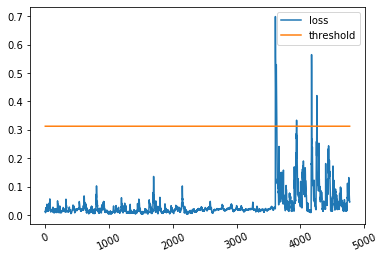

In [91]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [92]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,0,loss,threshold,anomaly
3607,3607,0.698463,0.312816,True
3608,3608,0.557502,0.312816,True
3609,3609,0.541120,0.312816,True
3610,3610,0.519665,0.312816,True
3611,3611,0.493401,0.312816,True


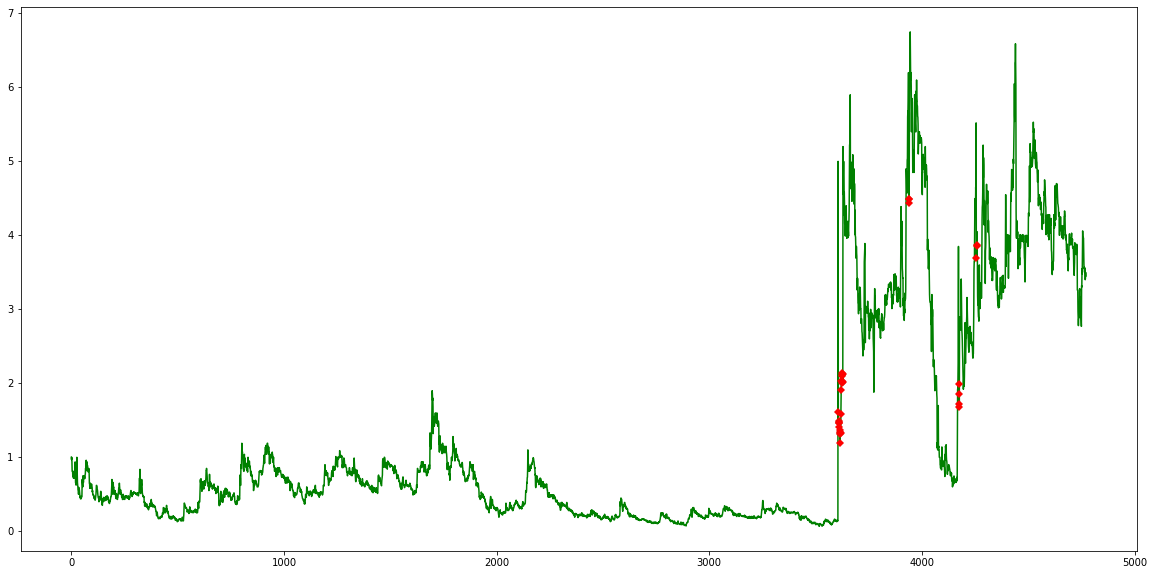

In [93]:
pred_plot = []
for ys in X_test_pred:
    pred_plot.append(ys[0]*(max_value-min_value)+min_value)
    
for i in range(len(x_test)):
    if i not in anomalies.index:
        pred_plot[i] = (y_test[i][0]*(max_value-min_value))+min_value
    else:
        pred_plot[i] = (pred_plot[i] + close_value[i] +close_value[i])/3
    
plt.figure(figsize=(20,10))
plt.plot(pred_plot, '-gD', markevery=list(anomalies.index), markeredgewidth = 0.02 , markerfacecolor = "red")

plt.savefig(f'{file_name}_normalised.png')

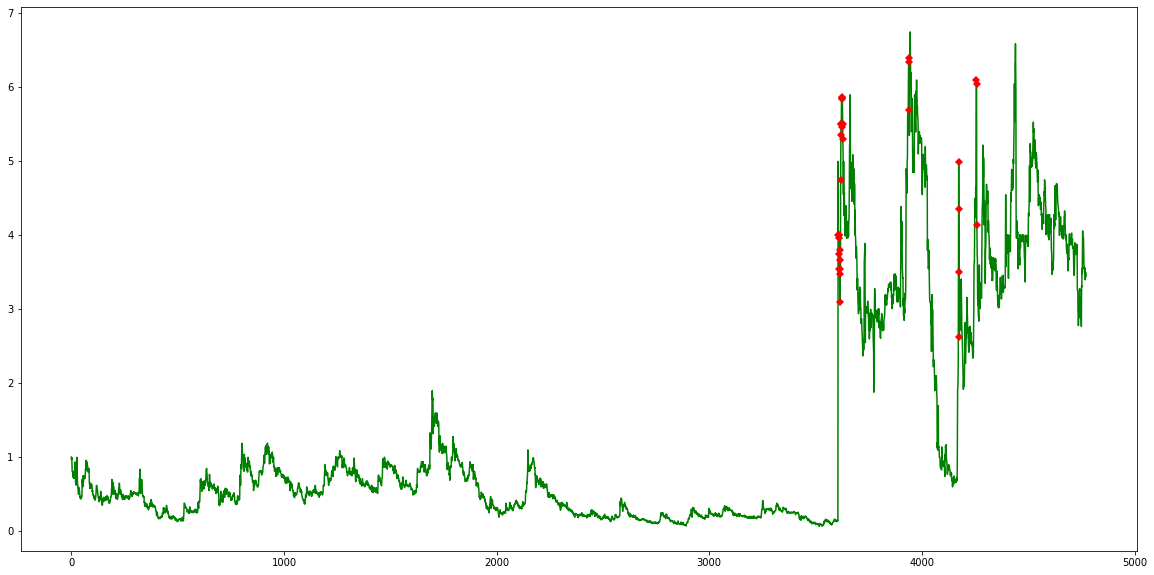

In [94]:
y_plot = []
for y1 in y_test:
    y_plot.append(y1[0]*(max_value-min_value)+min_value)
plt.figure(figsize=(20,10))
plt.plot(y_plot, '-gD', markevery=list(anomalies.index), markeredgewidth = 0.02 , markerfacecolor = "red")
plt.savefig(f'{file_name}_anomaly.png')